## Check preprocessing

/Users/gianlucacalo/anaconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/gianlucacalo/anaconda3/envs/ml/lib/python3.11/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


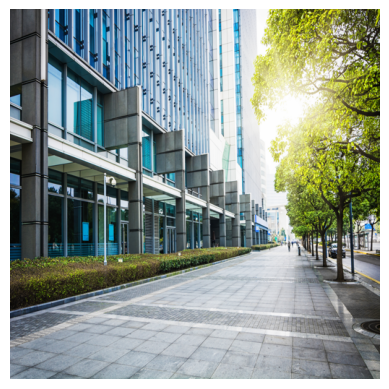

torch.uint8 torch.Size([3, 512, 512])
torch.Size([1, 3, 512, 512]) torch.Size([3, 512, 512])


False

In [1]:
from PIL import Image
import requests
from landslide.data import preprocess
from matplotlib import pyplot as plt
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import torch


# Specify the model name
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"

# Load the pretrained model and feature extractor
m2 = SegformerForSemanticSegmentation.from_pretrained(model_name)
feature_extractor = SegformerImageProcessor.from_pretrained(model_name)

# Download and open the image
url = "https://leeruben-rae-2.hf.space/file=/home/user/app/c-1.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image = image.resize((512, 512))

plt.imshow(image)
plt.axis("off")
plt.show()

# Preprocess the image using the feature extractor
i1 = feature_extractor(images=image, return_tensors="pt")
i2 = preprocess(image)

print(i1['pixel_values'].shape, i2.shape)
torch.allclose(i1["pixel_values"], i2, atol=1e-8)


## Check forward

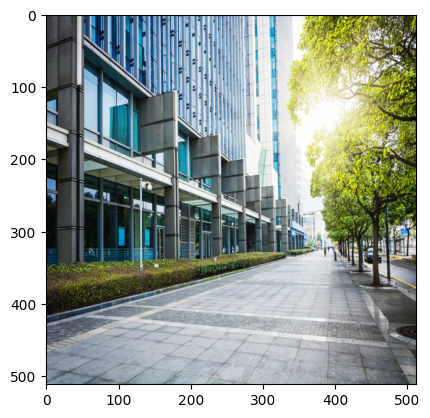

True

In [3]:

import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
import requests
from landslide.data import preprocess
from matplotlib import pyplot as plt
import torch
import numpy as np
from safetensors import safe_open




""" Original impl """
from transformers import SegformerForSemanticSegmentation as original, SegformerFeatureExtractor as original_fe
# Specify the model name
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"

# Load the pretrained model and feature extractor
m1 = original.from_pretrained(model_name)
feature_extractor = original_fe.from_pretrained(model_name)
# ====================================================================================================



""" My impl """
from landslide.model.segformer import SegformerForSemanticSegmentation, SegformerConfig

config = SegformerConfig()
config.num_labels = 150
m2 = SegformerForSemanticSegmentation(config)

tensors = {}

model_keys = m2.state_dict().keys()
# Load the weights from safetensor file
with safe_open("../models/segformer-b0-finetuned-ade-512-512/model.safetensors", framework="pt", device="cpu") as f:
    # Get all available keys from the safetensor file
    keys = f.keys()

    # Load each tensor into the dictionary
    for k in keys:
        tensors[k] = f.get_tensor(k)


# Load the state dict into the model
m2.load_state_dict(tensors, strict=True)
# ====================================================================================================


url = "https://leeruben-rae-2.hf.space/file=/home/user/app/c-1.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image = image.resize((512, 512))
image = np.array(image)

plt.imshow(image)
plt.show()

# x = preprocess(image, size=(512, 512), do_normalize=True)
# x = x.unsqueeze(0)

x = feature_extractor(images=image, return_tensors="pt")

m1.eval()
m2.eval()

with torch.inference_mode():
    l1 = m1(**x)
    l2 = m2(x["pixel_values"])



assert l1.logits.shape == l2.shape, "mismatch"
torch.allclose(l1.logits, l2, atol=1e-8) # False


In [1]:
from landslide.model.segformer import SegformerForSemanticSegmentation, SegformerConfig
import torch

config = SegformerConfig()
config.num_labels = 1

model = SegformerForSemanticSegmentation(config)

inputs = torch.randn(1, 3, 512, 512)
outputs = model(inputs)
outputs.shape

torch.Size([1, 1, 128, 128])